In [67]:
def jacobian(ds, bed, density_dict, grav_mskd, g_z, perturb_scale=1, quiet=True):

    res = np.abs(ds.x.values[1]-ds.x.values[0])

    x_vary = xx[ds.inv_msk.values==True]
    y_vary = yy[ds.inv_msk.values==True]
    bed_vary = ds.bed.values[ds.inv_msk.values==True]
    surface_vary = ds.surface.values[ds.inv_msk.values==True]
    thickness_vary = ds.thickness.values[ds.inv_msk.values==True]

    water_dens = density_dict['water']
    rock_dens = density_dict['rock']
    
    jac = np.zeros((grav_mskd.shape[0], bed_vary.size))

    pbar = tqdm(range(bed_vary.size), position=0, leave=True, disable=quiet)
    for i in pbar:
        pos = rng.random()*perturb_scale
        neg = -1*rng.random()*perturb_scale
        bed_pos = bed_vary[i]+pos
        bed_neg = bed_vary[i]+neg
        water_top = surface_vary[i]-thickness_vary[i]
        j = 0
        while bed_pos > water_top:
            pos = rng.random()
            bed_pos = bed_vary[i]+pos
            if j > 20:
                bed_pos = water_top - 1e-8
                break
            j += 1
        prism_current = [x_vary[i]-res/2, x_vary[i]+res/2, y_vary[i]-res/2, y_vary[i]+res/2, bed_vary[i], water_top]
        prism_pos = [x_vary[i]-res/2, x_vary[i]+res/2, y_vary[i]-res/2, y_vary[i]+res/2, bed_pos, water_top]
        prism_neg = [x_vary[i]-res/2, x_vary[i]+res/2, y_vary[i]-res/2, y_vary[i]+res/2, bed_neg, water_top]
    
        prisms_water, idx_water_pos = split_prisms(np.array([prism_current]))
        d_water = np.where(idx_water_pos, water_dens, water_dens-rock_dens)
        g_z_current = hm.prism_gravity(pred_coords, prisms_water, d_water, field='g_z')
    
        prisms_water, idx_water_pos = split_prisms(np.array([prism_pos]))
        d_water = np.where(idx_water_pos, water_dens, water_dens-rock_dens)
        g_z_pos = hm.prism_gravity(pred_coords, prisms_water, d_water, field='g_z')
    
        prisms_water, idx_water_pos = split_prisms(np.array([prism_neg]))
        d_water = np.where(idx_water_pos, water_dens, water_dens-rock_dens)
        g_z_neg = hm.prism_gravity(pred_coords, prisms_water, d_water, field='g_z')
    
        terrain_pos = g_z - g_z_current + g_z_pos
        terrain_neg = g_z - g_z_current + g_z_neg
    
        res_pos = target - terrain_pos
        res_neg = target - terrain_neg
    
        grad = (res_pos-res_neg)/(bed_pos-bed_neg)
        jac[:,i] = grad

    return jac

In [68]:
jac = jacobian(ds, ds.bed.values, density_dict, grav_mskd, bm_terrain, perturb_scale=5, quiet=False)

  0%|          | 0/1468 [00:00<?, ?it/s]

In [69]:
jac.max()

np.float64(-1.8520629940400734e-09)

In [70]:
jac.shape

(3471, 1468)

In [71]:
np.count_nonzero(jac > 0)

0

In [72]:
x_vary[5], y_vary[5]

(np.float64(-1887500.0), np.float64(-442500.0))

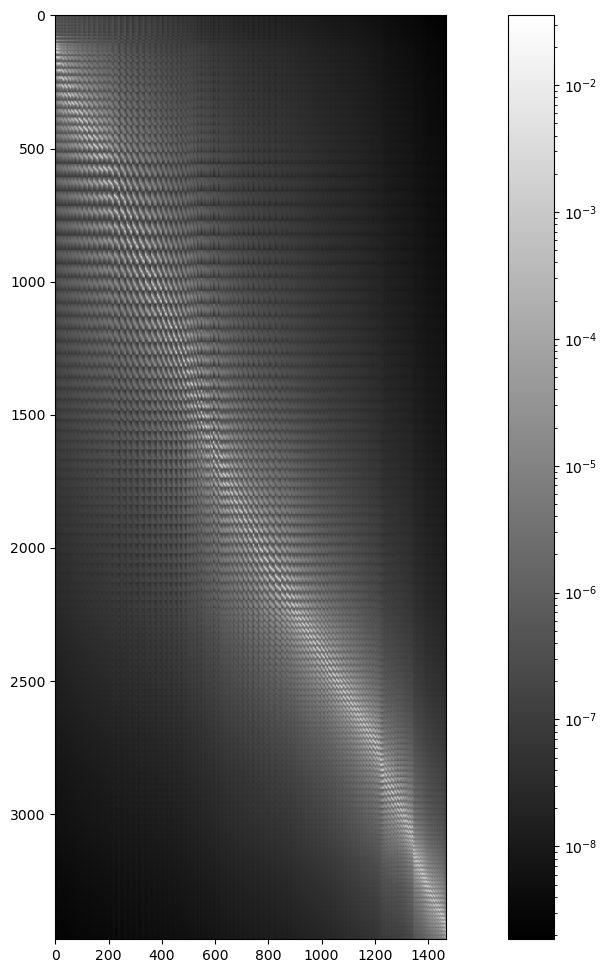

In [73]:
import matplotlib.colors as colors

jac_abs = np.abs(jac)

plt.figure(figsize=(16,12))
im = plt.imshow(jac_abs, cmap='binary_r', norm=colors.LogNorm(vmin=jac_abs.min(), vmax=jac_abs.max()))
# im = plt.imshow(jac, cmap=cm.vik, vmin=-0.02, vmax=0.02)
# im = plt.imshow((jac>0)[:10,:10], cmap=cm.vik)
plt.colorbar(im)
plt.show()

In [74]:
def gauss_newton(ds, target, grav_mskd, density_dict, n_iter=5, alpha=1, perturb_scale=1, quiet=True):
    x_vary = xx[ds.inv_msk.values==True]
    y_vary = yy[ds.inv_msk.values==True]
    prev_bed = ds.bed.values[ds.inv_msk.values==True]

    bed_cache = np.zeros((n_iter, *ds.bed.shape))

    prisms, densities = make_prisms(ds, ds.bed.values, density_dict)
    pred_coords = (grav_mskd.x, grav_mskd.y, grav_mskd.height)
    g_z = hm.prism_gravity(pred_coords, prisms, densities, field='g_z')
    residual = target - g_z
    rmse_next = np.sqrt(np.mean(np.square(residual)))
    print(f'# start \t RMSE: {rmse_next:.3f}')
    
    for i in range(n_iter):
        
        J = jacobian(ds, prev_bed, density_dict, grav_mskd, g_z, perturb_scale=1, quiet=True)

        delta = -1*np.linalg.inv(J.T@J)@J.T@residual
        next_bed = prev_bed + alpha*delta

        next_bed_grid = xy_into_grid(ds, (x_vary, y_vary), next_bed)
        next_bed_grid = np.where(np.isnan(next_bed_grid), ds.bed.values, next_bed_grid)
        prisms, densities = make_prisms(ds, next_bed_grid, density_dict)
        g_z_next = hm.prism_gravity(pred_coords, prisms, densities, field='g_z')
        residual = target-g_z_next
        rmse_next = np.sqrt(np.mean(np.square(residual)))

        bed_cache[i,...] = next_bed_grid
        prev_bed = next_bed

        print(f'# {i+1} \t RMSE: {rmse_next:.3f}')

    return bed_cache

In [75]:
bed_cache = gauss_newton(ds, target, grav_mskd, density_dict, n_iter=15, alpha=0.2, perturb_scale=5, quiet=True)

# start 	 RMSE: 10.763
# 1 	 RMSE: 8.663
# 2 	 RMSE: 7.044
# 3 	 RMSE: 5.783
# 4 	 RMSE: 4.800
# 5 	 RMSE: 3.961
# 6 	 RMSE: 3.262
# 7 	 RMSE: 2.703
# 8 	 RMSE: 2.268
# 9 	 RMSE: 1.917
# 10 	 RMSE: 1.645
# 11 	 RMSE: 1.437
# 12 	 RMSE: 1.278
# 13 	 RMSE: 1.145
# 14 	 RMSE: 1.041
# 15 	 RMSE: 0.959


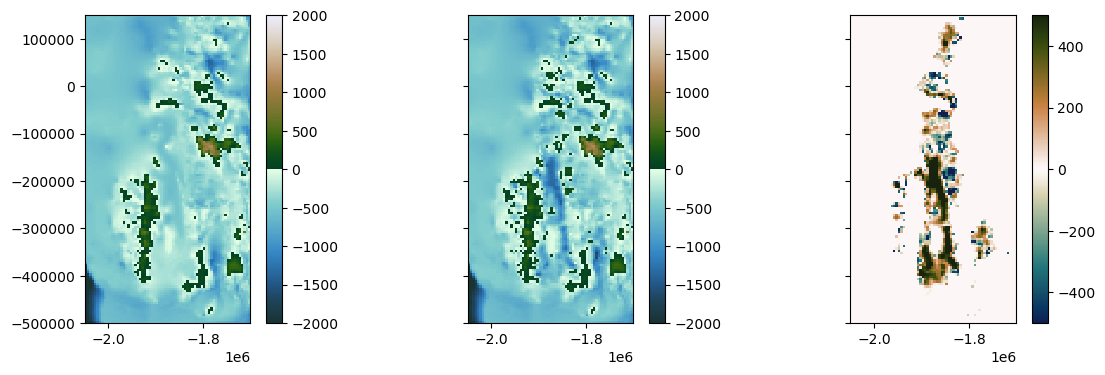

In [76]:
index = 14

fig, axs = plt.subplots(1, 3, figsize=(14,4), sharey=True)

ax = axs[0]
im = ax.pcolormesh(ds.x, ds.y, ds.bed, cmap=cm.bukavu, vmin=-2000, vmax=2000)
ax.axis('scaled')
plt.colorbar(im, ax=ax)

ax = axs[1]
im = ax.pcolormesh(ds.x, ds.y, bed_cache[index,...], cmap=cm.bukavu, vmin=-2000, vmax=2000)
ax.axis('scaled')
plt.colorbar(im, ax=ax)

ax = axs[2]
im = ax.pcolormesh(ds.x, ds.y, ds.bed-bed_cache[index,...], cmap='cmo.tarn_r', vmin=-500, vmax=500)
ax.axis('scaled')
plt.colorbar(im, ax=ax)
plt.show()

In [77]:
next_bed = bed_vary - np.linalg.inv(jac.T@jac)@jac.T@residual0

In [78]:
next_bed_grid = xy_into_grid(ds, (x_vary, y_vary), next_bed)
next_bed_grid = np.where(np.isnan(next_bed_grid), ds.bed.values, next_bed_grid)

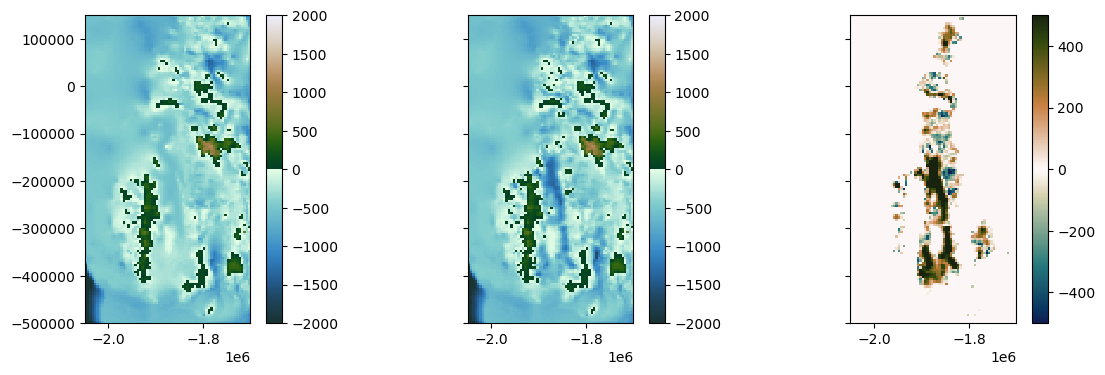

In [79]:
fig, axs = plt.subplots(1, 3, figsize=(14,4), sharey=True)

ax = axs[0]
im = ax.pcolormesh(ds.x, ds.y, ds.bed, cmap=cm.bukavu, vmin=-2000, vmax=2000)
ax.axis('scaled')
plt.colorbar(im, ax=ax)

ax = axs[1]
im = ax.pcolormesh(ds.x, ds.y, next_bed_grid, cmap=cm.bukavu, vmin=-2000, vmax=2000)
ax.axis('scaled')
plt.colorbar(im, ax=ax)

ax = axs[2]
im = ax.pcolormesh(ds.x, ds.y, ds.bed-next_bed_grid, cmap='cmo.tarn_r', vmin=-500, vmax=500)
ax.axis('scaled')
plt.colorbar(im, ax=ax)
plt.show()

In [80]:
prisms, densities = make_prisms(ds, bed_cache[10,...], density_dict)
pred_coords = (grav_mskd.x, grav_mskd.y, grav_mskd.height)
g_z_new = hm.prism_gravity(pred_coords, prisms, densities, field='g_z')

In [81]:
g_z_new_grid = xy_into_grid(ds, (pred_coords[0], pred_coords[1]), g_z_new)
residual_new_grid = target_grid-g_z_new_grid

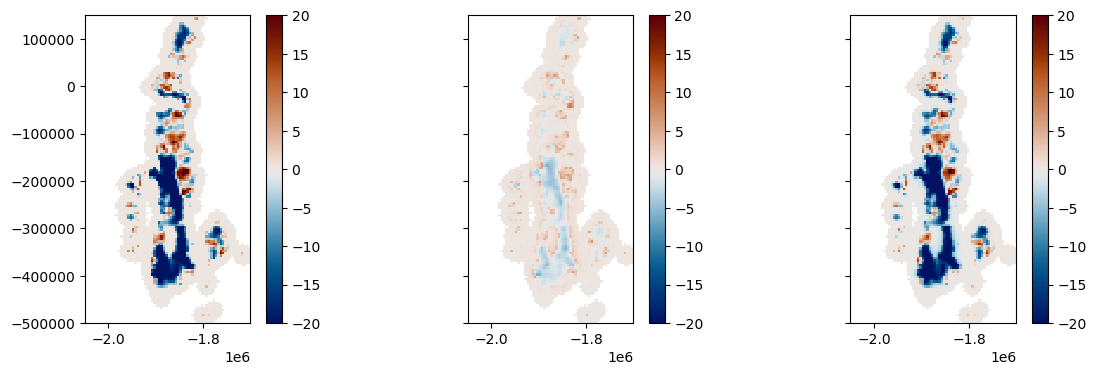

In [82]:
vmax = 20

fig, axs = plt.subplots(1, 3, figsize=(14,4), sharey=True)

ax = axs[0]
im = ax.pcolormesh(ds.x, ds.y, residual0_grid, cmap=cm.vik, vmin=-vmax, vmax=vmax)
ax.axis('scaled')
plt.colorbar(im, ax=ax)

ax = axs[1]
im = ax.pcolormesh(ds.x, ds.y, residual_new_grid, cmap=cm.vik, vmin=-vmax, vmax=vmax)
ax.axis('scaled')
plt.colorbar(im, ax=ax)

ax = axs[2]
im = ax.pcolormesh(ds.x, ds.y, residual0_grid-residual_new_grid, cmap=cm.vik, vmin=-vmax, vmax=vmax)
ax.axis('scaled')
plt.colorbar(im, ax=ax)
plt.show()

In [83]:
rmse0 = np.sqrt(np.mean(np.square(residual0)))
rmse_new = np.sqrt(np.mean(np.square(target-g_z_new)))

rmse0, rmse_new

(np.float64(10.76276810161126), np.float64(1.436819483498991))

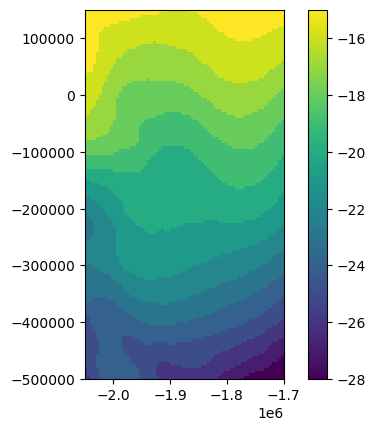

In [84]:
plt.pcolormesh(ds.x, ds.y, ds.geoid)
plt.axis('scaled')
plt.colorbar()
plt.show()

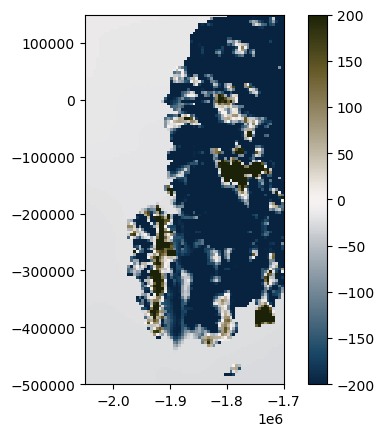

In [85]:
plt.pcolormesh(ds.x, ds.y, ds.surface - ds.thickness, cmap='cmo.diff', vmin=-200, vmax=200)
plt.axis('scaled')
plt.colorbar()
plt.show()

In [86]:
10**(-4)

0.0001

In [87]:
from scipy.ndimage import gaussian_filter

alpha = 1
m=gaussian_filter(ds.bed.values,alpha)

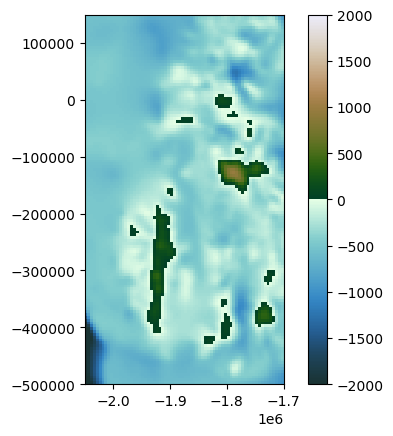

In [88]:
plt.pcolormesh(ds.x, ds.y, m, cmap=cm.bukavu, vmin=-2000, vmax=2000)
plt.axis('scaled')
plt.colorbar()
plt.show()

In [89]:
dy, dx = np.gradient(ds.bed.values, 5e3)
ddx = np.gradient(dx, 5e3, axis=1)
ddy = np.gradient(dy, 5e3, axis=0)

l2x = np.sqrt(np.sum(np.square(ddx)))
l2y = np.sqrt(np.sum(np.square(ddy)))
print(f'x : {l2x} y : {l2y}')

x : 0.0002546832256484777 y : 0.0002168095816159621


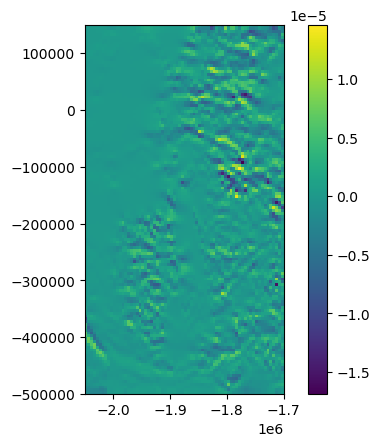

In [90]:
plt.pcolormesh(ds.x, ds.y, ddy)
plt.axis('scaled')
plt.colorbar()
plt.show()

In [91]:
l2ys = []
l2xs = []

for i in range(bed_cache.shape[0]):
    dy, dx = np.gradient(bed_cache[i,...], 5e3)
    ddx = np.gradient(dx, 5e3, axis=1)
    ddy = np.gradient(dy, 5e3, axis=0)
    l2x = np.sqrt(np.sum(np.square(ddx[ds.inv_msk])))
    l2y = np.sqrt(np.sum(np.square(ddy[ds.inv_msk])))
    print(f'x : {l2x} y : {l2y}')
    l2xs.append(l2x)
    l2ys.append(l2y)

x : 8.306306773723112e-05 y : 6.944981694894607e-05
x : 0.00010069256901873665 y : 8.400059716775513e-05
x : 0.00011846257525223564 y : 9.94540290698493e-05
x : 0.00013477853306509099 y : 0.00011420172647835561
x : 0.00014926895055797061 y : 0.0001277345948811954
x : 0.00016168598466834356 y : 0.00013942414965210267
x : 0.00017215852739343567 y : 0.0001492216416050341
x : 0.00018096456214328178 y : 0.00015739388496672824
x : 0.00018836104980891823 y : 0.00016426862973927062
x : 0.00019455387912332753 y : 0.00017005213285770427
x : 0.00019977876200198415 y : 0.00017496028655591462
x : 0.00020424128662818793 y : 0.00017920998811891606
x : 0.0002080997560201012 y : 0.00018291580180870102
x : 0.000211406787125849 y : 0.00018611927941800533
x : 0.0002142481038670029 y : 0.00018889287338000232


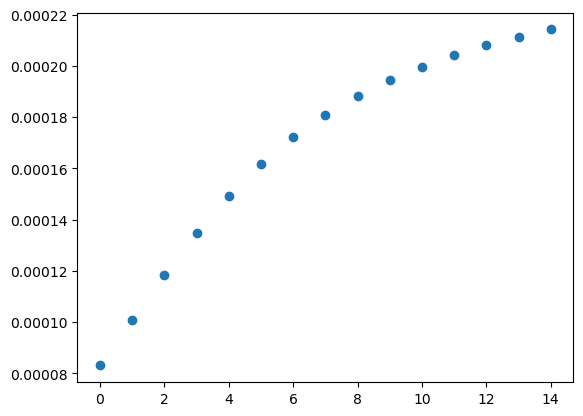

In [92]:
plt.plot(np.arange(15), l2xs, 'o')
plt.show()